## Demonstration of layer sharing on LeNet-5

In [1]:
PATH_PREFIX = '../../'
import sys
sys.path.append(PATH_PREFIX)

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import os

from data.mnist import MnistDataset
from data.utils.mnist_utils import *
from models.lenet.lenet import LeNet5
from utils.weight_sharing import *
from utils.plot import *

Parameters

In [3]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = None
EPOCHS = 100

NET_PATH =  os.path.join(PATH_PREFIX, 'models/lenet/saves/lenet_tanh.save')
SAVE_DATA = os.path.join(PATH_PREFIX, 'results/test_share.csv')

Setting up the components

In [4]:
dataset = MnistDataset(BATCH_SIZE, os.path.join(PATH_PREFIX, 'data'), val_split=0.5)
model = LeNet5(N_CLASSES, 'tanh')
criterion = nn.CrossEntropyLoss()

lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_test, lam_opt, lam_train)
ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Getting the network

In [5]:
optimizer = lam_opt(model)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings)

In [6]:
lam_test()

0.9864

In [7]:
#ws_controller.share_total(10, 1, 1, plot=True, assign=True)

<Figure size 640x480 with 0 Axes>

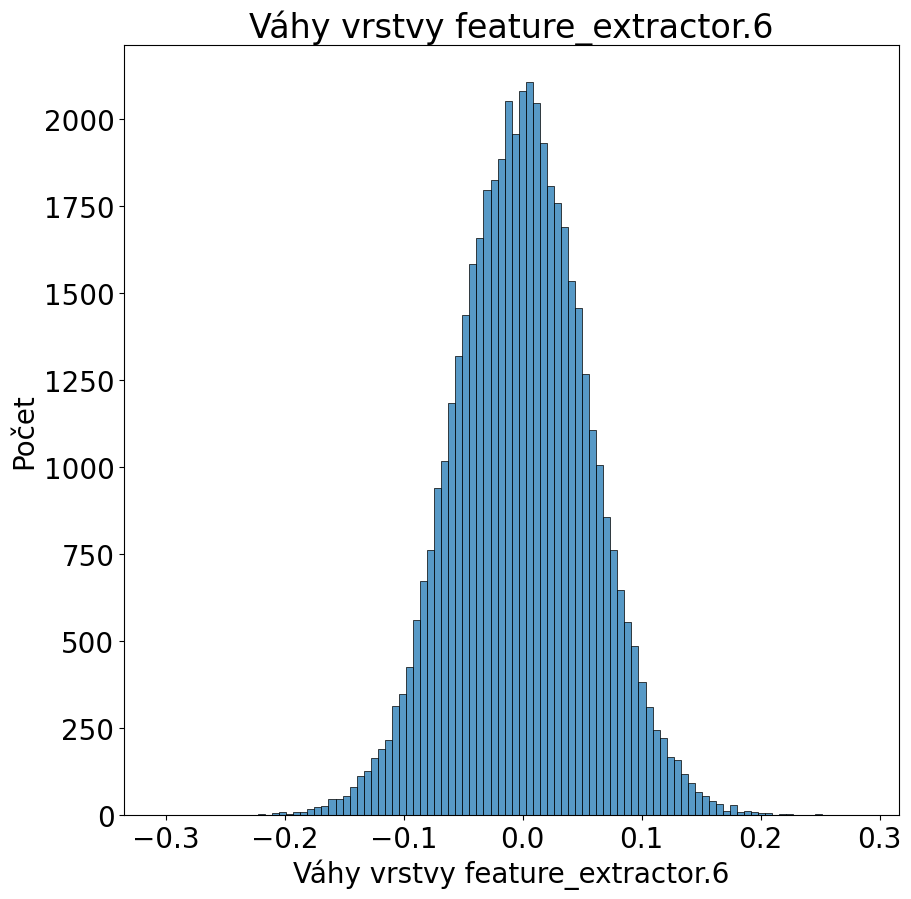

In [8]:
#sns.set(font_scale=1.5, style='white')
ws_controller.model_layers[2].plot_weight()

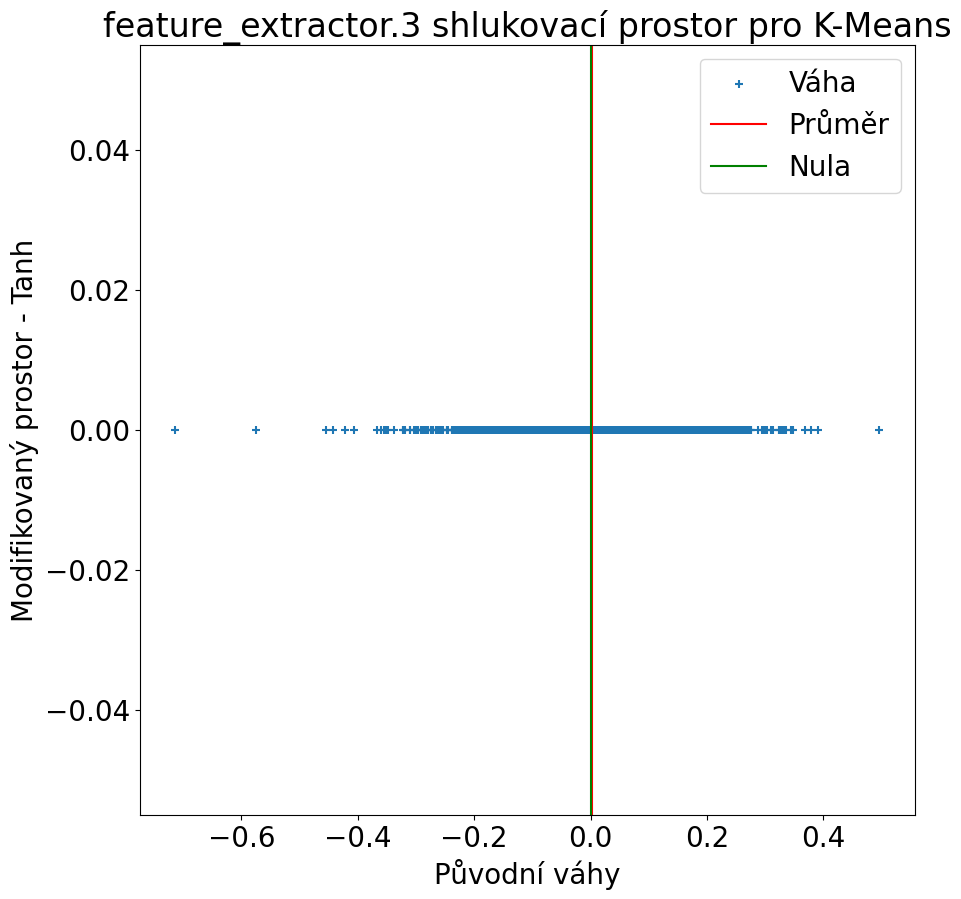

<Figure size 640x480 with 0 Axes>

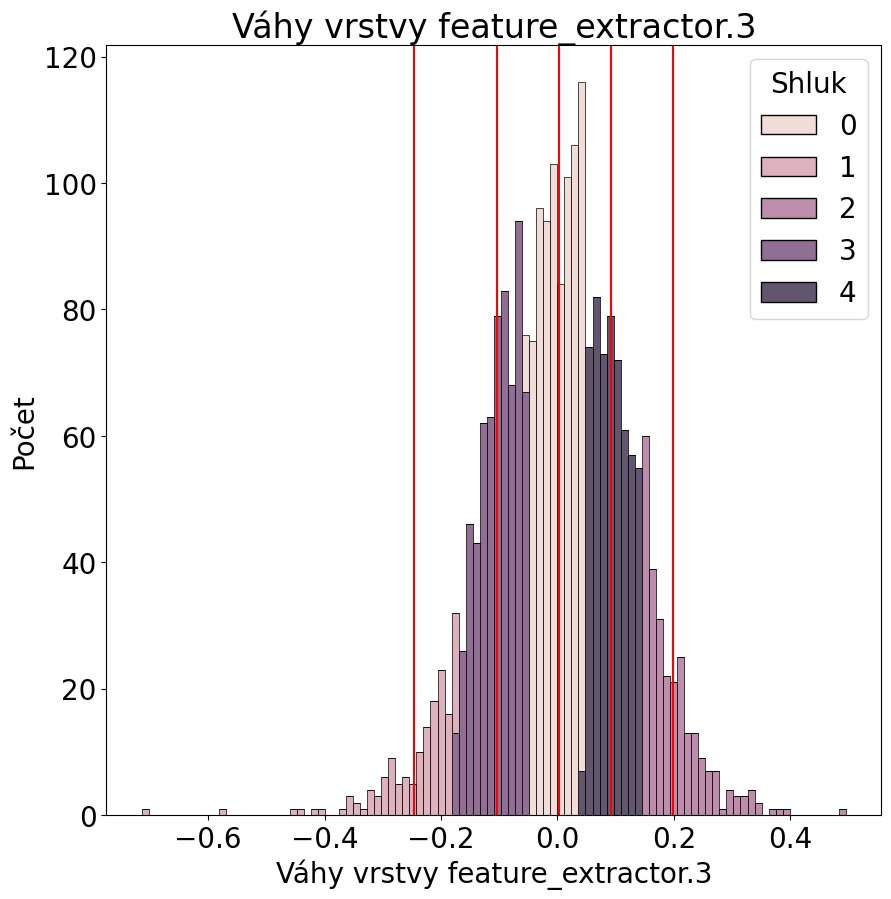

In [9]:
ws_controller.model_layers[1].share_weight(5, plot=True, mod_focus=0, mod_spread=2)

TEST - Sharing the whole network to given parameters

In [10]:

ws_controller.share([4, 4, 7, 10, 4], verbose=True)

# u tanh lenetu
# mods=[0, 0, 0, 0, 0] 'accuracy': 0.9738
# mods=[2, 2, 2, 2, 2] 'accuracy': 0.9808,

# cr 11.98956930434724

# share time kmeans - 0.8162627220153809 acc - 0.9738
# share time minibatchkmeans - 0.22685647010803223 acc - 0.977

Share: 1/5 ---  Time: 0.01s	 Name: feature_extractor.0	Before params: 150	 After params: 4	
Share: 2/5 ---  Time: 0.13s	 Name: feature_extractor.3	Before params: 2400	 After params: 4	
Share: 3/5 ---  Time: 0.05s	 Name: feature_extractor.6	Before params: 48000	 After params: 7	
Share: 4/5 ---  Time: 0.07s	 Name: classifier.0	Before params: 10080	 After params: 10	
Share: 5/5 ---  Time: 0.04s	 Name: classifier.2	Before params: 840	 After params: 4	


{'accuracy': 0.977,
 'compression': 11.98956930434724,
 'inertias': [0.6739407181739807,
  4.88079833984375,
  7.325132369995117,
  2.1700026988983154,
  4.560333251953125],
 'times': {'train': 0,
  'share': 0.2995290756225586,
  'test': 1.9715042114257812}}

<Figure size 640x480 with 0 Axes>

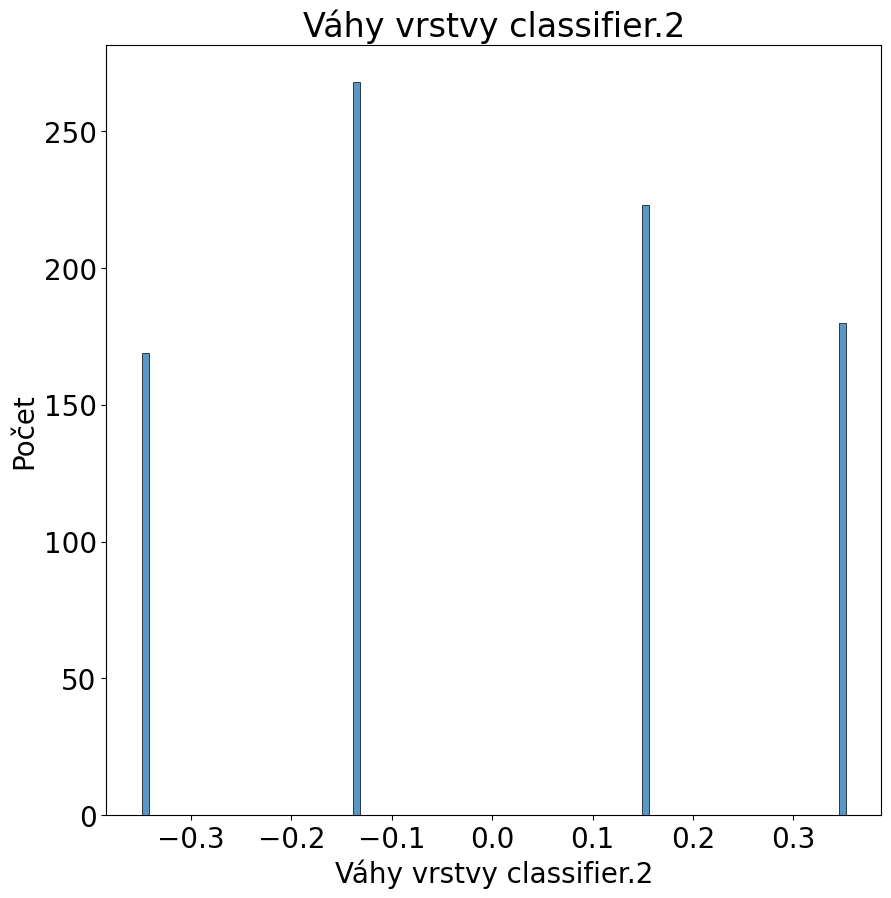

In [11]:
ws_controller.model_layers[4].plot_weight()